In [2]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams.update({'font.size': 12})
pylab.rcParams.update({'font.family': 'sans serif'})
pylab.rcParams.update({'mathtext.default':'regular'})
pylab.rcParams.update({'mathtext.fontset':'stixsans'})
pylab.rcParams.update({'axes.linewidth': 1.5})
pylab.rcParams.update({'xtick.direction':'in'})
pylab.rcParams.update({'xtick.major.size': 5})
pylab.rcParams.update({'xtick.major.width': 1.25 })
pylab.rcParams.update({'xtick.minor.size': 2.5})
pylab.rcParams.update({'xtick.minor.width': 1.25 })
pylab.rcParams.update({'ytick.direction':'in'})
pylab.rcParams.update({'ytick.major.size': 5})
pylab.rcParams.update({'ytick.major.width': 1.25 })
pylab.rcParams.update({'ytick.minor.size': 2.5})
pylab.rcParams.update({'ytick.minor.width': 1.25 })

import warnings
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


# Constants and Initial Values

In [3]:
# conversion factors to get CGS units into Cholla units
MP = 1.6726E-24;  # proton mass in grams
KB = 1.380658e-16; # Boltzmann constant
LENGTH_UNIT = 3.08567758e21; # kpc in cm
TINY_NUMBER = 1.0e-20;
MASS_UNIT = 1.98855e33; # solar mass in grams
TIME_UNIT = 3.15569e10; # kyr in s
DENSITY_UNIT = (MASS_UNIT/(LENGTH_UNIT*LENGTH_UNIT*LENGTH_UNIT)); 
VELOCITY_UNIT = (LENGTH_UNIT/TIME_UNIT);
PRESSURE_UNIT = (DENSITY_UNIT*VELOCITY_UNIT*VELOCITY_UNIT);

"""this notebook uses the total gas metallicity instead of breaking contributions up by species"""
# solar abundances (percentage of total mass)
# O, C, N, Si, Mg, Ne, Fe, S
metals = np.array([0.0097, 0.0040, 0.00096, 0.00099, 0.00076, 0.00058, 0.0014, 0.00040]);
metallicity = np.sum(metals)

# gas density assuming number density of n ~ 10^-2 and composition of all hydrogen
n = 1e-2 # gas number density
d0_gas = MP * n * LENGTH_UNIT ** 3 / MASS_UNIT
d0_metal = metallicity * d0_gas
# assume 1% dust to gas fraction
d0_dust = d0_gas / 100
print("Gas inital density: {:.5E} M_sun/kpc^3".format(d0_gas))
print("Metal initial density: {:.5E} M_sun/kpc^3".format(d0_metal))
print("Dust inital density: {:.5E} M_sun/kpc^3".format(d0_dust))

# time array and range of temperatures for plotting analytic solutions
t_arr = np.logspace(0, 8, 1000)

T0_cells = [10, 100, 1000, 1e4, 1e5, 1e6, 1e7, 1e8]
T_colors = ["lightskyblue", "violet", "forestgreen", "darkviolet", "thistle", "cadetblue", 
            "palegoldenrod", "darksalmon", "indigo"]

Gas inital density: 2.47120E+05 M_sun/kpc^3
Metal initial density: 4.64338E+03 M_sun/kpc^3
Dust inital density: 2.47120E+03 M_sun/kpc^3


In [4]:
# functional form of differential equation
def d_dust_sputtering(d_i, T):
    a1 = 3; # dust grain size
    d0 = 1; # gas density
    T_0 = 2e6;
    omega = 2.5;
    A = 1.7e5; # units: kyr
    
    tau_sp = A * (a1/d0) * ((T_0/T) ** omega + 1);
    
    return -d_i / (tau_sp/3)

In [5]:
# time step
h = 1e2
t_arr = np.arange(0, 1e8, h)
d_dust = np.zeros(len(t_arr))
# initial value
d_dust[0] = d0_dust

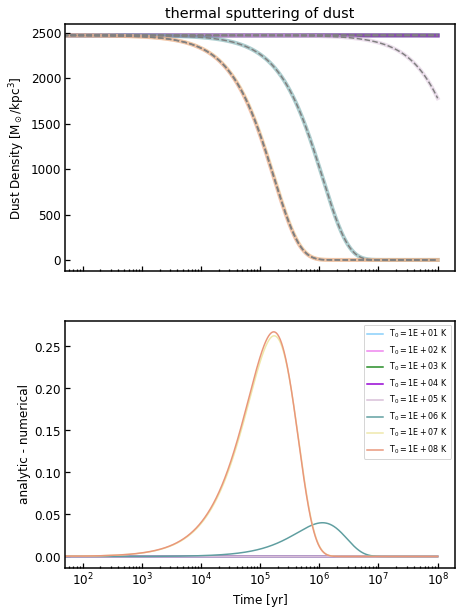

In [6]:
def thermal_sputtering(t, T, d0_dust):
    a1 = 3; # dust grain size
    d0 = 1; # gas density
    T_0 = 2e6;
    omega = 2.5;
    A = 1.7e5; # units: kyr
    
    tau_sp = A * (a1/d0) * ((T_0/T) ** omega + 1);
    
    return d0_dust * np.exp(-3*t/tau_sp)


fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(7,10))
for j, T in enumerate(T0_cells):
    for i, t_i in enumerate(t_arr):
        if (i + 1) < len(t_arr):
            # forward euler
            d_dust[i + 1] = d_dust[i] + h * d_dust_sputtering(d_dust[i], T)
    ax[0].semilogx(t_arr, d_dust, linestyle="--", color="grey")
    ax[0].semilogx(t_arr, thermal_sputtering(t_arr, T, d0_dust), color=T_colors[j], linewidth=4, alpha=0.5, zorder=0)
    ax[1].semilogx(t_arr, thermal_sputtering(t_arr, T, d0_dust) - d_dust, color=T_colors[j], label=f"$T_0={T:.0E}~K$")
    ax[1].set_xlabel("Time$~[yr]$")
    ax[0].set_ylabel(r"Dust Density$~[M_\odot/kpc^3]$")
    ax[1].set_ylabel("analytic - numerical")
    ax[1].legend(fontsize=8)
ax[0].set_title("thermal sputtering of dust")
plt.savefig("/Users/helenarichie/GitHub/helenarichie.github.io/assets/img/posts/sputtering_numerical.png", facecolor="white")

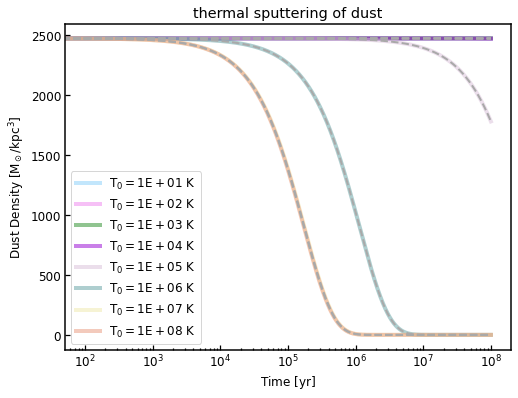

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8,6))
for j, T in enumerate(T0_cells):
    for i, t_i in enumerate(t_arr):
        if (i + 1) < len(t_arr):
            # forward euler
            d_dust[i + 1] = d_dust[i] + h * d_dust_sputtering(d_dust[i], T)
    ax.semilogx(t_arr, d_dust, linestyle="--", linewidth=2, color="darkgrey")
    ax.semilogx(t_arr, thermal_sputtering(t_arr, T, d0_dust), color=T_colors[j], linewidth=4, alpha=0.5, zorder=0, label=f"$T_0={T:.0E}~K$")
    ax.set_xlabel("Time$~[yr]$")
    ax.set_ylabel(r"Dust Density$~[M_\odot/kpc^3]$")
    ax.legend()
ax.set_title("thermal sputtering of dust")
plt.savefig("/Users/helenarichie/GitHub/helenarichie.github.io/assets/img/posts/sputtering_numerical.png", facecolor="white")